In [1]:
import numpy as np
%matplotlib inline
from models import params
from models.plottings import *
setup_levitator()

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]


# Vereinfachte Simulation des akustischen Levitators "Tiny-Lev"
Akustische Levitatoren sind Geräte, die auf der Wirkung von Ultraschallwellen basieren, um Gegenstände in der Luft zu schweben. Sie werden häufig in Laboren verwendet, um Gegenstände zu isolieren und zu untersuchen, ohne sie mit anderen Substanzen in Berührung zu bringen. Der Levitator besteht aus zwei oder mehr Sendern: Diese Ultraschallerzeuger erzeugen starke Ultraschallwellen. Die Sender sind so angeordnet, dass die Wellen an der Oberseite der zu levitierenden Substanz fokussiert werden, wodurch ein Druckgradient entsteht, der die Substanz schweben lässt.

Zur Vereinfachung wird im Folgenden zunächst ein vereinfachtes Modell des Gerätes, das nur aus 2 Sendern besteht verwendet.:

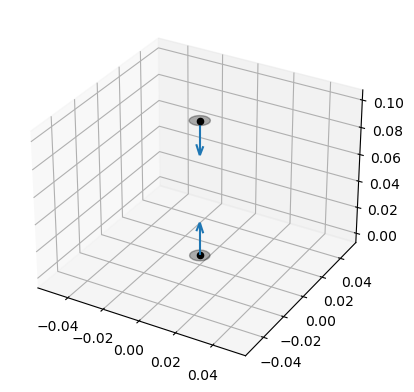

In [2]:
bottom_transducer = Transducer(np.array([0,0,0]), np.array([0,0,1]), 0)
top_transducer = Transducer(np.array([0,0,params.HEIGHT]), np.array([0,0,-1]), 0)

plot_transducers(bottom_transducer, top_transducer)

## Wellengleichungen
### Vereinfacht
Die von den Sendern ausgesandten Wellen verändern den Luftdruck an jedem Punkt des Levitators und erzeugen so ein akustisches Feld. Der akustische Druck $P$ im Punkt $p$ lässt sich durch folgende Wellengleichung bestimmen.
$\Psi(p)=sin(t+K*d)$
Hierbei steht $t$ für gegenwärtige Phase des Piezos, $d$ der Abstand des Piezos zum Punkt $p$ und $K=\frac{2\pi}{\lambda}$ ist die Wellenzahl.
Die zwei definierten Quellen erzeugen mit dieser Gleichung folgende Luftdruckruckfelder:

### Komplex: Direktivitätsfunktion $D_f(\theta)$

Die Näherung des Piezos als Punktquelle ist physikalisch allerdings unakkurat, wehalb die einfache Wellenfunktion $\Psi$ um Folgendes erweitert werden muss:
1. Die Stärke des akustischen Feldes verhält sich antiproportional zur Distanz vom Piezo zum Punkt $p$. So muss die Gleichung um den   Faktor $\frac1d$ erweitert werden.
2. Der Piezo erzeugt ein gerichtetes Druckfeld. Die Senderichtung eines Piezos wird durch einen Normalenvektor $\vec{n}$ beschrieben, der orthogonal auf dessen Membran steht. Je größer der Winkel zwischen der Normalen $\vec(n)$ und dem Punkt ist, desto kleiner wird das Feld. So muss eine Direktivitätsfunktion $D_f(\theta)$ definiert, die vom Winkel $\theta$ zwischen Normalen und Punkt abhängt.

Der Winkel $\theta$ lässt sich über das Skalarprodukt der Piezonormalen $\vec{n}$ und des Vektors $\vec{Tp}$ vom Piezo zum Punkt $p$ berechnen. Es gilt
$\theta = arccos(\frac{\vec{n} * \vec{Tp}}{|\vec{n}| * |\vec{Tp}|})$
Die Direktivitätsfunktion für einen Piezo lautet
$D_f(\theta) = \frac{2*J_1(k*a*sin(\theta)}{k*a*sin(\theta)}$
mit $J_1$ als erste Bessel Funktion erster Ordnung und dem Membranradius $a$.
Sie kann mit
$D_f(\theta) \approx sinc(k*a*sin(\theta) = \frac{sin(k*a*sin(\theta)}{\theta}$
angenähert werden. So ergibt sich folgende Wellenintensität um den Sender im Bereich den Levitators.

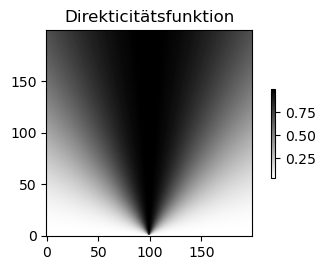

In [3]:
plot_directivity_function()

Im Folgenden werden immer die vereinfachte Wellen der Wellenfunktion $\Psi$ auf der linken Seite und die komplexe Wellenfunktion $P$ auf der rechten. Aus den erläuterten Gleichungen ergeben sich folgende Wellen:

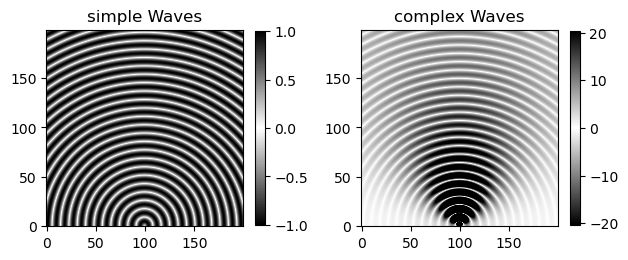

In [4]:
plot_pressure_waves(transducers=bottom_transducer, left="simple", right="complex")

## Interferenz
### Stehende Wellen
Überlagern sich zwei Wellen, entsteht Interferenz. Das bedeutet, dass sich die Wellen addieren. Im besonderen Falle, dass die interferierenden Wellen von gleicher Frequenz, Phase und Amplitude sind bilden sich Knotenpunkte und Wellenbäuche. In den Knotenpunkten ändert sich der Luftdruck nicht. An den Wellenbäuchen oszilliert er stark.
Ein solches Interferenzbild $I$ kann durch die Addition der interferierenden Wellen berechnet werden:
$I=\sum_{i=1}^{n}P_i$
Die zwei Sender des Vereinfachten Levitators erzeugen folgendes Interferenzbild.

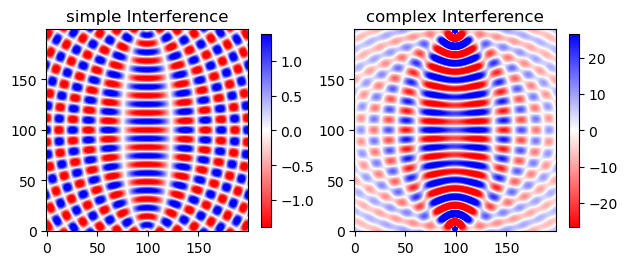

In [5]:
plot_interference([[bottom_transducer], [top_transducer]], left="simple", right="complex")

Während der Druck an einem Knotenpunkt konstant null ist verläuft der Druck in einem Wellenbauch wie folgt:

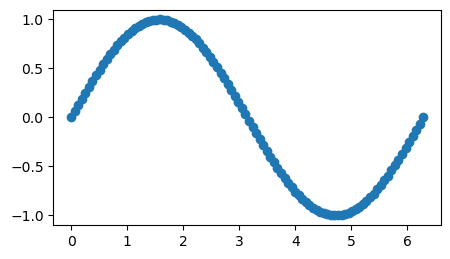

In [6]:
plot_pressure_over_time(bottom_transducer, np.array([0,.05,0]))

### Bestimmen von Knotenpunkten und Wellenbäuchen
Da der Druck an den Knotenpunkten konstant neutral ist, während er sich unmittelbar daneben an den Wellenäuchen stark ändert, kommt es zu Druckgradienten. Diese sorgen ultimativ für die Kraft, die ein Objekt schweben lässt. Es gilt also Knotenpunkte und Wellenbäuche im Interferenzbild ausfindig zu machen. Hierfür gitb es allerdings eine Schwierigkeit:

Für jeden Zeitpunkt $t=n*\pi \forall n \in \mathbb{N}$ gilt $P=0$. Dies stellt ein Problem zur Identifikation der Knoten dar, da diese in diesen Zeitpunkten nicht mehr von den Bäuchen unterschieden werden können. In einem Aufbau mit mehr als zwei Sendern ist es nicht mehr möglich dieses Problem durch das Betrachten eines eindeutigen Zeitpunktes zu umgehen, da die Phase jeder Welle von der Distanz jedes Senders zum Punkt abhängt. Somit sind alle Wellen zu verschiedenen Zeitpunkten in der kritischen Phase.
Eine Möglichkeit dieses Problem zu lösen, ist die Bestimmung der absoluten Luftdruckänderung eines Punktes über die gesamte Phase hinweg. Diese Druckänderung ist in der obenstehenden Abbildung die Fläche $A$, die der Luftdruck mit der Zeit einschließt. Diese lässt sich berechnen mit
$A = |\int_{0}^{\pi} P \,dt| + |\int_{\pi}^{2*\pi} P \,dt|$

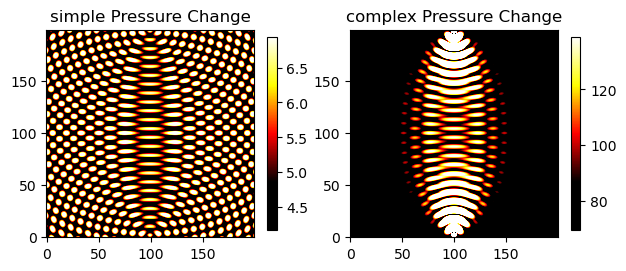

In [7]:
plot_pressure_change(([bottom_transducer], [top_transducer]), left="simple", right="complex")

In den schwazen Bereichen gilt nun, dass der Luftdruck dort relativ konstant ist, also eine geringe Druckänderung vorliegt. In den hervorgehobenen Bereichen ändert sich der Druck stark. Da die Kraft, die ein Präparat schweben lässt, relativ zur Änderung dieses Drucks ist, ist Levitation in den schwarzen Bereichen möglich, die in alle Richtungen durch große Druckänderungen begrenzt sind.

# Vollständige Simulation

In dem tatsächlich verwendeten Levitator werden $2*36$ Sender verwendet, die jeweils oben und unten so auf einer Halbschale angeordnet sind, dass die auf den Mittelpunkt des Gerätes fokussiert sind.

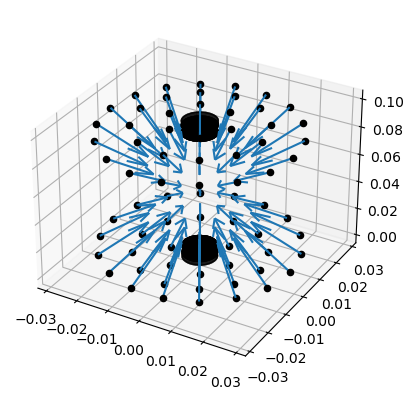

In [8]:
plot_transducers()

Diese Sender erzeugen folgende Wellen

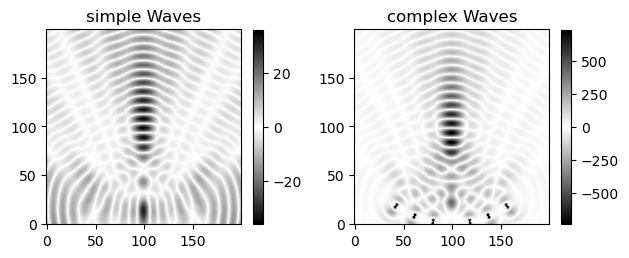

In [9]:
plot_pressure_waves(left="simple", right="complex")

So entsteht folgendes Interferenzbild

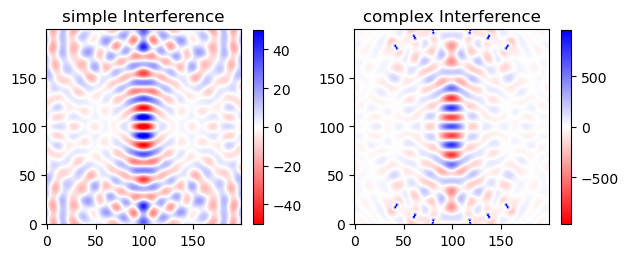

In [10]:
plot_interference(left="simple", right="complex")

Es ergibt sich folgende Druckänderung

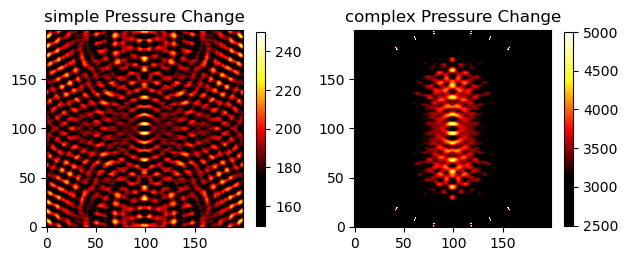

In [11]:
plot_pressure_change(left="simple", right="complex")

# Interpretation

Da für die physikalische Interpretation der Plots nur die akkurate Version relevant ist, wird im Folgenden nur noch diese betrachtet.

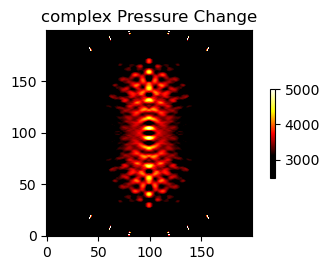

In [12]:
plot_pressure_change(left="complex")

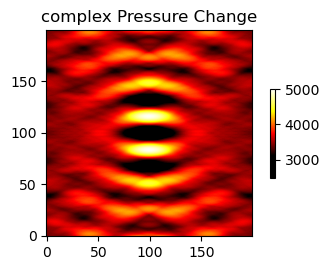

In [2]:
x = np.linspace(-.01,.01, params.RES)
z = np.linspace((params.HEIGHT/2)-.015, (params.HEIGHT/2)+.015, params.RES)
x,z = np.meshgrid(x,z)

plot_pressure_change(left="complex", x=x, z=z)

Der Zoom in das Zentrum das Levitators offenbart zwei Eigenschaften des Levitators:
1. Das Verwenden vieler Sender erzeugt ein wesentlich stärker auf das Zentrum fokussiertes Feld
2. Die schwarzen Knoten, in denen Levitation möglich ist, sind stärker nach oben und unten abegegrenzt, als zu denm Seiten. Die Kraft ist somit stärker in vertikaler Richtung.

# Visualisierung der Kräfte

Die Kraft $F$, die auf ein schwebendes Teilchen wirkt, wirkt immer von Gebieten einer hohen Druckänderung $A$ zu Gebieten geringer Druckänderung. Sie wirkt also entlang des Druckänderungsgradienten. Es gilt
$F\sim \frac{dA}{dx,dy,dz}$
Diese Beziehung lässt sich visualisieren, indem man die Druckänderung in einem Oberflächenplot darstellt.

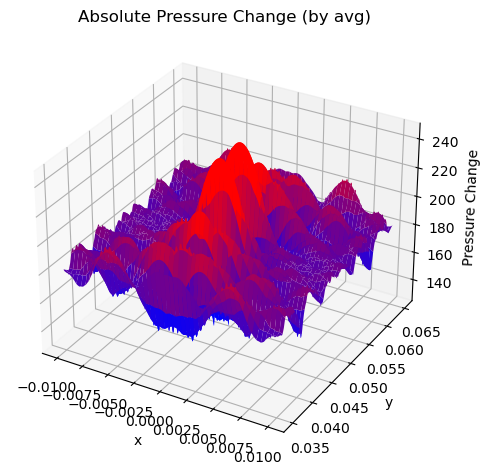

In [3]:
plot_plane(x=x, z=z)

In dieser Darstellung kann sich ein schwebendes Objekt als Kugel vorgestellt werden. Wird sie an einem Punkt hohen Potentials/Druckänderung platziert, rollt sie auf schnellstem Wege in das nächstgelegene Tal (blau) und erreicht so ein niedrigeres Potential. Aus diesem Tal kann das Objekt ohne zusätzliche Energie nicht mehr entweichen. Es ist dort gefangen - schwebt also an einem Punkt minimalen Potentials im Raum.

# Weiterführende Überlegungen

1. Um die Kräfte, die durch das Feld erzeugt werden besser verstehen zu können wäre es interessant diese anhand der Ableitung des Druckes in alle drei Raumrichtungen zu bestimmen. Hierbei kann sich die Linearität einer Ableitung zunutze gemacht werden. Die Ableitung in einem Punkt kann also für jede Welle des Feldes einzeln berechnet und dann addiert werden. Die Kraft wirkt dann entgegegesetzt der Ableitung.
2. Da an jedem Punkt der Simulation wahrheitsgetreue Einheiten genutzt wurden, wäre es möglich die Kräfte nicht nur über die Ableitungen darzustellen, sondern diese sogar akkurat zu berechnen. So kann man Aussagen über die Leistungsfähigkeit des Levitators treffen.